In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure

In [2]:
dictionary = pd.read_excel('../Data_project/Data_dictionary.xlsx', sheet_name = ['Public Records Dictionary', 'Loan Performance Dictionary', 'Public Record Type Codes', 'Public Record Source Type Codes'])

# Loan Performance

### 1. Data Preparation:

In [3]:
loan = pd.read_csv('../Data_project/Loan_performance.csv')

In [4]:
loan.head()

,analytics_matchkey,max_loan_amount,late_30_days,late_60_days,late_90_days
0,1346745,2500,0,0,0
1,1346746,1000,0,0,0
2,1346747,1002,0,0,0
3,1346748,1500,0,0,0
4,1346749,1675,0,0,0


In [5]:
loan.shape

(646127, 5)

In [6]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646127 entries, 0 to 646126
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   analytics_matchkey  646127 non-null  int64
 1   max_loan_amount     646127 non-null  int64
 2   late_30_days        646127 non-null  int64
 3   late_60_days        646127 non-null  int64
 4   late_90_days        646127 non-null  int64
dtypes: int64(5)
memory usage: 24.6 MB


In [7]:
loan.describe()

,analytics_matchkey,max_loan_amount,late_30_days,late_60_days,late_90_days
count,6.461270e+05,646127.000000,646127.000000,646127.000000,646127.000000
mean,1.669828e+06,1742.545930,0.121569,0.091559,0.081602
std,1.865318e+05,730.869254,0.326788,0.288403,0.273757
min,1.346745e+06,1000.000000,0.000000,0.000000,0.000000
25%,1.508286e+06,1166.000000,0.000000,0.000000,0.000000
50%,1.669831e+06,1500.000000,0.000000,0.000000,0.000000
75%,1.831370e+06,2076.000000,0.000000,0.000000,0.000000
max,1.992908e+06,4000.000000,1.000000,1.000000,1.000000


In [8]:
len(loan) == len(loan['analytics_matchkey'].unique())

True

In [9]:
loan.sort_values(by = 'analytics_matchkey')

,analytics_matchkey,max_loan_amount,late_30_days,late_60_days,late_90_days
0,1346745,2500,0,0,0
1,1346746,1000,0,0,0
2,1346747,1002,0,0,0
3,1346748,1500,0,0,0
4,1346749,1675,0,0,0
...,...,...,...,...,...
646122,1992904,1671,0,0,0
646123,1992905,2000,0,0,0
646124,1992906,1400,1,1,1
646125,1992907,3000,1,1,1


In [10]:
print(
    len(loan[loan.late_90_days > loan.late_60_days]), 
    len(loan[loan.late_60_days > loan.late_30_days]),
    len(loan[loan.late_90_days > loan.late_30_days])
)

0 0 0


### 2.  Analysis

In [11]:
corr = loan[['max_loan_amount', 'late_30_days', 'late_60_days', 'late_90_days']].corr()
corr

,max_loan_amount,late_30_days,late_60_days,late_90_days
max_loan_amount,1.000000,-0.009254,-0.010001,-0.009392
late_30_days,-0.009254,1.000000,0.853386,0.801265
late_60_days,-0.010001,0.853386,1.000000,0.938924
late_90_days,-0.009392,0.801265,0.938924,1.000000


<Axes: xlabel='max_loan_amount', ylabel='Count'>

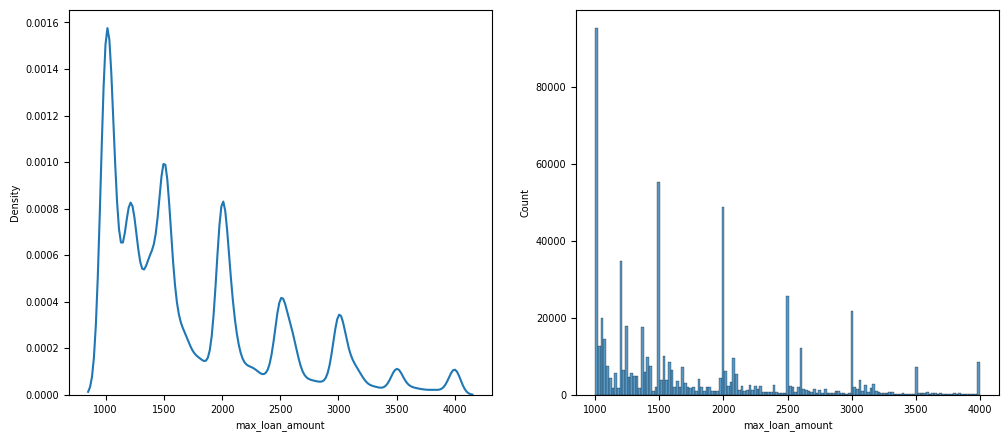

In [137]:
fig, axes = plt.subplots(1,2, figsize = (12, 5))
sns.kdeplot(loan.max_loan_amount, ax = axes[0])
sns.histplot(loan.max_loan_amount, ax = axes[1])

In [13]:
def late_proportion(df, late, ax):
    #graphs a barplot that shows the fraction of missed payments of a chosen category/categories to all the loans made in the dataset df
    proportion = (df[late].sum()/len(df)).reset_index()
    proportion.columns = ['late_days', 'late_per_loan']
    bplot = sns.barplot(data=proportion, 
                x='late_days', 
                y='late_per_loan',
                width = 0.4,
                ax = ax
                )
    bplot.bar_label(bplot.containers[0], fmt='%.3f')
    return bplot

In [14]:
loan_D = loan[:]
loan_D['late_between_30_and_60'] =  loan['late_30_days'] - loan['late_60_days']
loan_D['late_between_60_and_90'] = loan['late_60_days'] - loan['late_90_days']

(0.0, 0.1)

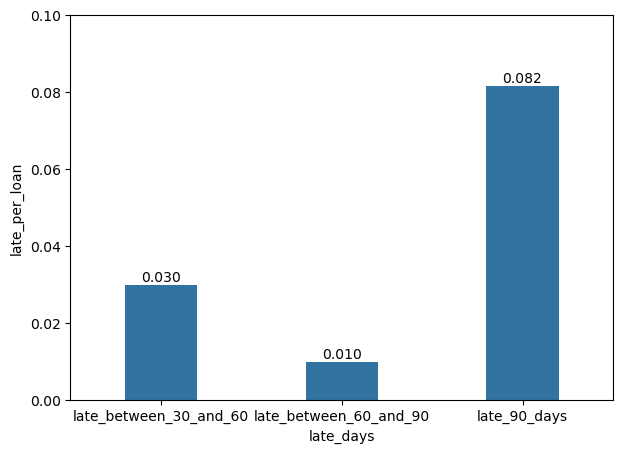

In [16]:
figure(figsize = (7, 5))
late_proportion(loan_D, ['late_between_30_and_60', 'late_between_60_and_90', 'late_90_days'], ax = plt.gca())
plt.gca().set_ylim(0, 0.1) 

given that the payment is late by at least 30 days, what's the propbability that it is:
  - late_between_30_and_60
   - late_between_60_and_90
   - late_90_days

I will define a function that graphs PDFs of the r.v. L(S= {late_between_30_60, late_between_60_90, late_90+}, which will be helpful when applying filters from public records

In [23]:
def if_late_how(df, late, ax, graph):
    how_late = (df[late].sum()/df['late_30_days'].sum()).reset_index()
    how_late.columns = ['late_days', 'if_late_how_long']
    if not graph:
        return how_late
    late_plot = sns.barplot(data=how_late, 
                            x='late_days', 
                            y='if_late_how_long',
                            width = 0.4,
                            ax = ax
                            )
    late_plot.bar_label(late_plot.containers[0], fmt='%.2f')

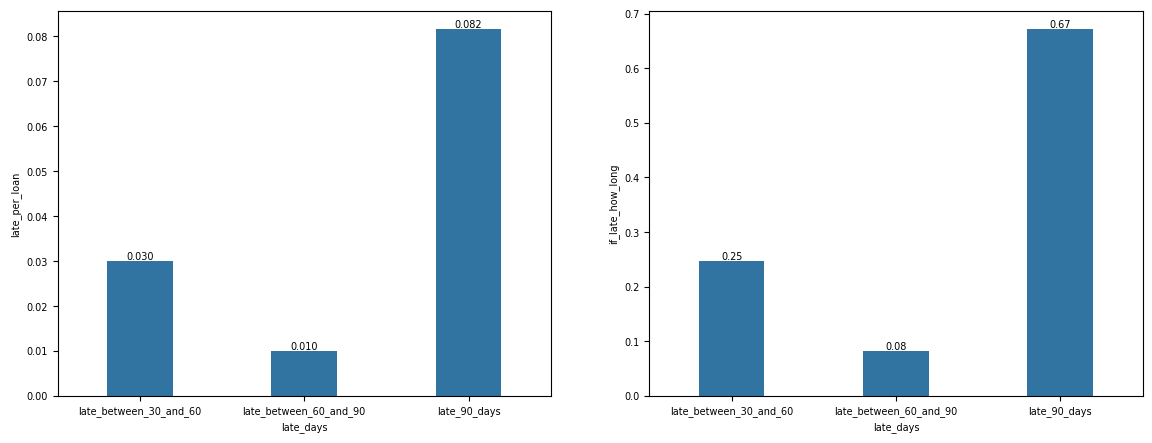

In [31]:
fig, axes = plt.subplots(1,2, figsize = (14, 5))
plt.rcParams.update({'font.size': 7})
late_proportion(loan_D, ['late_between_30_and_60', 'late_between_60_and_90', 'late_90_days'], axes[0])
if_late_how(loan_D, ['late_between_30_and_60', 'late_between_60_and_90', 'late_90_days'], axes[1], True)

25% of late pmts are 30-60 days late (75% of late pmts are more than 30 days late)  
8% of late pmts are 60-90 days late (33% of late pmts are no later than 90 days)  
67% of late pmtrs are more than 90 days late

late 90 days is of interest in here, because in most cases, after you've missed 90 days of loan pmts, the lender considers you to be in default

<Axes: xlabel='max_loan_amount', ylabel='Count'>

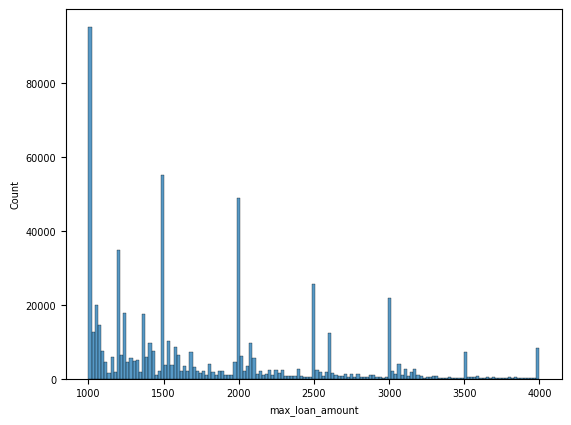

In [138]:
sns.histplot(loan_D.max_loan_amount)

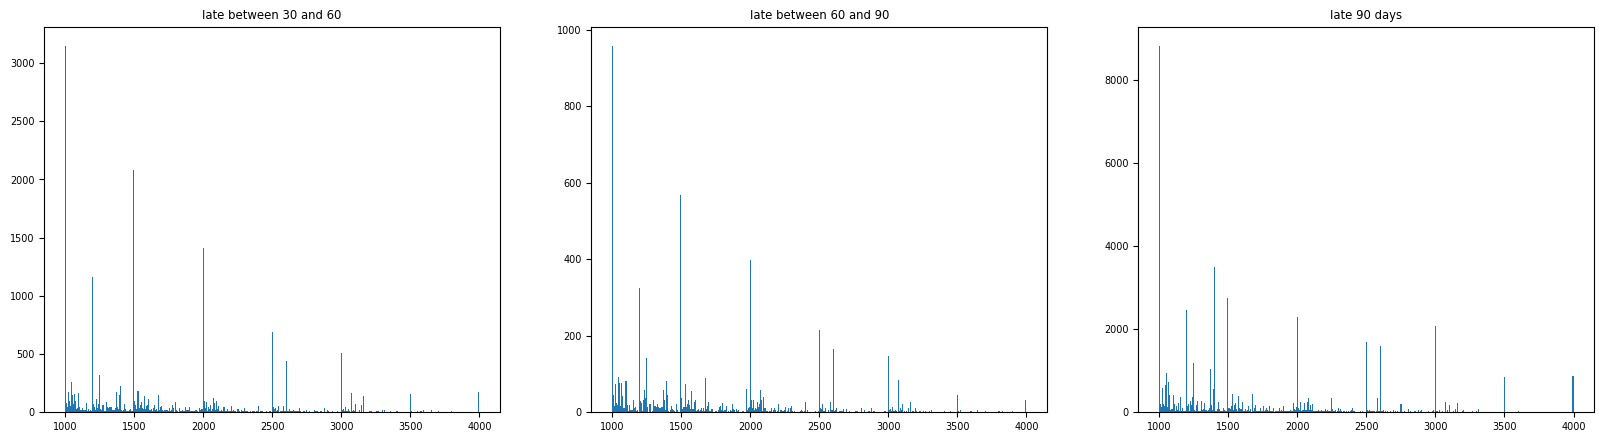

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
ax[0].hist(loan_D[loan_D['late_between_30_and_60'] ==1]['max_loan_amount'], bins = 400)
ax[0].set_title('late between 30 and 60')
ax[1].hist(loan_D[loan_D['late_between_60_and_90'] ==1]['max_loan_amount'], bins = 400)
ax[1].set_title('late between 60 and 90')
ax[2].hist(loan_D[loan_D['late_90_days'] ==1]['max_loan_amount'], bins = 400)
ax[2].set_title('late 90 days')
plt.show()

1400 looks very suspicious, because there are a lot of missed pmts at 90 days

In [27]:
loan1400 = loan_D.query('max_loan_amount == 1400')
loan1400.shape

(8497, 7)

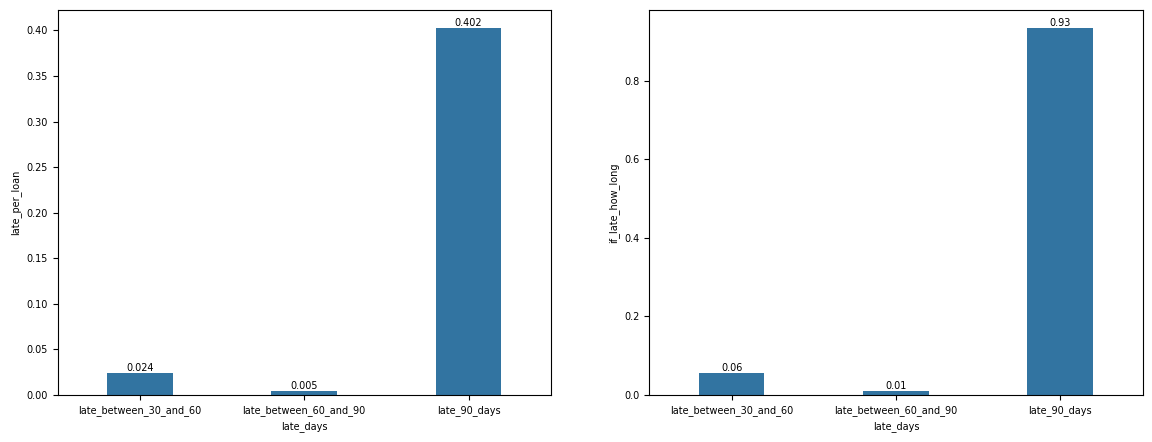

In [30]:
fig, axes = plt.subplots(1,2, figsize = (14, 5))
plt.rcParams.update({'font.size': 7})
late_proportion(loan1400, ['late_between_30_and_60', 'late_between_60_and_90', 'late_90_days'], axes[0])
if_late_how(loan1400, ['late_between_30_and_60', 'late_between_60_and_90', 'late_90_days'], axes[1], True)

Summary;
Conclusions

# Public Records

In [4]:
dictionary['Public Records Dictionary']

,Variable Name:,Description:,Format:,Len:,Start Pos:,End Pos:,Mask:,Mask Length:,Mask Char:,Blank
0,Analytics Matchkey,Unique customer identifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Record Type,Code identifying record type,NaN,2.0,1.0,2.0,,,,
2,Sequence Number,First 10 bytes is the number assigned to a con...,NaN,12.0,3.0,14.0,,,,
3,Industry Code (Kind of Business),A code used to categorize subscribers by their...,NaN,2.0,15.0,16.0,,,,
4,Reporting Subscriber Code,Internal trade line identifier. The first 4 b...,NaN,7.0,17.0,23.0,left,4,,Y
5,Public Record Type Code,Identifies the type of public record.,NaN,2.0,24.0,25.0,,,,
6,Effective Date (Date Verified),Date when the Reporting Subscriber took cogniz...,YYYYMMDD,8.0,26.0,33.0,,,,
7,Filed Date,Date when the Record became officially public.,YYYYMMDD,8.0,34.0,41.0,,,,
8,Paid Date,Displays the date the subject paid the assesse...,YYYYMMDD,8.0,42.0,49.0,,,,
9,Amount,Displays the original amount in the case.,NaN,9.0,50.0,58.0,,,,


In [5]:
public = pd.read_csv('../Data_project/Public_records.csv')

In [6]:
public.head()

,analytics_matchkey,industry_code_kind_of_business,reporting_subscriber_code,public_record_type_code,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number
0,1346747,ZP,99,CJ,20130604.0,20130129,NaN,1209.0,CI,I,1,NaN,NaN,NaN
1,1346748,ZP,485,7X,20140925.0,20140506,20140924.0,NaN,FE,I,1,NaN,NaN,NaN
2,1346754,Z,11R,SL,20120124.0,20110405,NaN,2248.0,RD,I,1,NaN,NaN,NaN
3,1346754,ZP,1,7X,20130129.0,20120928,20130128.0,NaN,FE,C,1,NaN,NaN,NaN
4,1346756,ZP,1,RL,20140913.0,20070202,20140801.0,406.0,RD,I,1,NaN,NaN,NaN


In [7]:
public.describe().round(2)

,analytics_matchkey,effective_date_date_verified,filed_date,paid_date,amount,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number
count,218303.00,218018.00,218303.00,129421.00,156792.00,218303.00,0.0,0.0,0.0
mean,1669626.91,20127969.43,20119092.31,20123806.98,4616.67,1.07,NaN,NaN,NaN
std,186294.23,22330.04,22517.19,22600.83,41800.84,0.26,NaN,NaN,NaN
min,1346747.00,20070119.00,20060406.00,20061129.00,0.00,1.00,NaN,NaN,NaN
25%,1508168.00,20110706.00,20100826.00,20110224.00,644.00,1.00,NaN,NaN,NaN
50%,1669451.00,20130430.00,20120319.00,20121126.00,1338.00,1.00,NaN,NaN,NaN
75%,1831498.00,20150224.00,20140213.00,20140812.00,3174.00,1.00,NaN,NaN,NaN
max,1992902.00,20160929.00,20160927.00,20160928.00,9999999.00,2.00,NaN,NaN,NaN


In [8]:
public.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218303 entries, 0 to 218302
Data columns (total 14 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   analytics_matchkey                 218303 non-null  int64  
 1   industry_code_kind_of_business     218303 non-null  object 
 2   reporting_subscriber_code          218303 non-null  object 
 3   public_record_type_code            218303 non-null  object 
 4   effective_date_date_verified       218018 non-null  float64
 5   filed_date                         218303 non-null  int64  
 6   paid_date                          129421 non-null  float64
 7   amount                             156792 non-null  float64
 8   public_record_source_type_code     218302 non-null  object 
 9   equal_credit_opportunity_act_code  218303 non-null  object 
 10  legislative_prohibited_code        218303 non-null  int64  
 11  plaintiff_name                     0 no

Convert datetime values to appropriate format, delete columns that have no values:

In [9]:
public['filed_date'] = pd.to_datetime(public['filed_date'], format='%Y%m%d')
public['effective_date_date_verified'] = pd.to_datetime(public['effective_date_date_verified'], format='%Y%m%d')
public['paid_date'] = pd.to_datetime(public['paid_date'], format='%Y%m%d')
public = public.drop(['plaintiff_name', 'attorney_name', 'docket_number'], axis = 1)

**There are some, but not many NA values in effective_date_date_verified and public_record_source_type_code, so it's safe to drop them**

In [21]:
public[public.duplicated()]

,analytics_matchkey,industry_code_kind_of_business,reporting_subscriber_code,public_record_type_code,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code
3277,1356310,ZP,34,SL,2014-03-08,2014-01-02,NaT,846.0,RD,I,1
3278,1356310,ZP,34,SL,2014-03-08,2014-01-02,NaT,846.0,RD,I,1
4521,1359868,Z,11J,SL,2011-07-27,2011-07-21,NaT,2689.0,RD,I,1
4541,1359869,Z,11J,SL,2011-07-27,2011-07-21,NaT,2689.0,RD,I,1
6448,1365380,ZP,165,TL,2014-07-09,2014-05-30,NaT,262.0,RD,C,1
...,...,...,...,...,...,...,...,...,...,...,...
204133,1949392,Z,406,SL,2014-08-20,2014-07-14,NaT,625.0,RD,I,1
205148,1952447,ZP,138,RL,2014-10-28,2013-06-20,2014-10-01,1210.0,RD,I,1
210569,1968879,ZP,490,RL,2011-09-07,2011-01-27,2011-07-29,425.0,RD,I,1
213138,1977172,ZP,25M,RL,2016-04-17,2014-08-15,2014-08-29,79.0,RD,C,1


In [15]:
public = public.dropna(subset = 'effective_date_date_verified').dropna(subset = 'public_record_source_type_code')

In [16]:
public.isna().sum()

analytics_matchkey                       0
industry_code_kind_of_business           0
reporting_subscriber_code                0
public_record_type_code                  0
effective_date_date_verified             0
filed_date                               0
paid_date                            88451
amount                               61468
public_record_source_type_code           0
equal_credit_opportunity_act_code        0
legislative_prohibited_code              0
dtype: int64

**Some entries have a non-NA paid_date and 0 in amount. You can't pay a zero. These entries are invalid, so we should drop them**

In [12]:
zero_paid = public.loc[public['amount'] == 0 & public['paid_date'].notna()]
len(zero_paid)

774

In [13]:
public.drop(list(zero_paid.index), axis=0, inplace=True)

**Some codes were not in the dictionary. Need to update the dictionary. I asked ChatGPT for the missing codes and put them into excel**

There are 134717 unique analytics_matchkey.s (compared to 218303 non-unique analytics_matchkey.s in the dataset, which means that there can be multiple records per customer)

In [15]:
public.value_counts('analytics_matchkey').describe()

count    134303.000000
mean          1.617559
std           1.318967
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          87.000000
Name: count, dtype: float64

### Variable analysis ###

In [3]:
industry, record_type, record_source = [public.groupby(col)[:] for col in ['industry_code_kind_of_business', 
                                                                                            'public_record_type_code', 
                                                                                            'public_record_source_type_code', 
                                                                                            ]]
 

NameError: name 'public' is not defined

In [20]:
public_M = public[public['amount'] > 0]

In [21]:
public_M['amount'].describe().round(2)

count     155775.00
mean        4627.79
std        41888.04
min           12.00
25%          652.00
50%         1347.00
75%         3192.00
max      9999999.00
Name: amount, dtype: float64

(0.0, 10000.0)

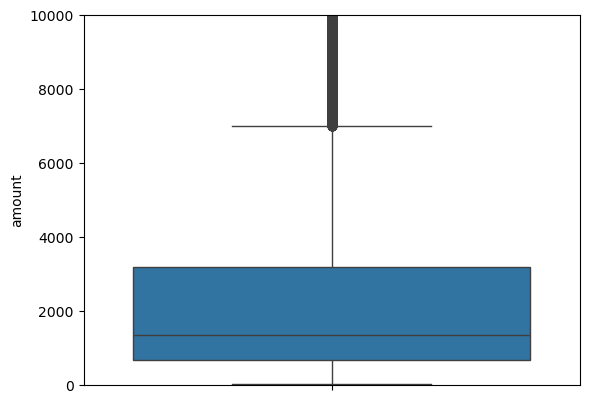

In [22]:
sns.boxplot(
    y = 'amount',
    data = public_M
    )
plt.gca().set_ylim(0, 10000) 

throw away outliers using IQR

In [23]:
Q1 = public_M['amount'].quantile(0.25) 
Q3 = public_M['amount'].quantile(0.75)
IQR = Q3 - Q1
l_bound = Q1 - 1.5 * IQR
u_bound = Q3 + 1.5 * IQR
public_M = public_M[(public_M['amount'] >= l_bound) & (public_M['amount'] <= u_bound)]

In [24]:
public_M['amount'].describe().round(2)

count    137402.0
mean       1675.0
std        1520.3
min          12.0
25%         592.0
50%        1148.0
75%        2247.0
max        7002.0
Name: amount, dtype: float64

<Axes: xlabel='amount', ylabel='Count'>

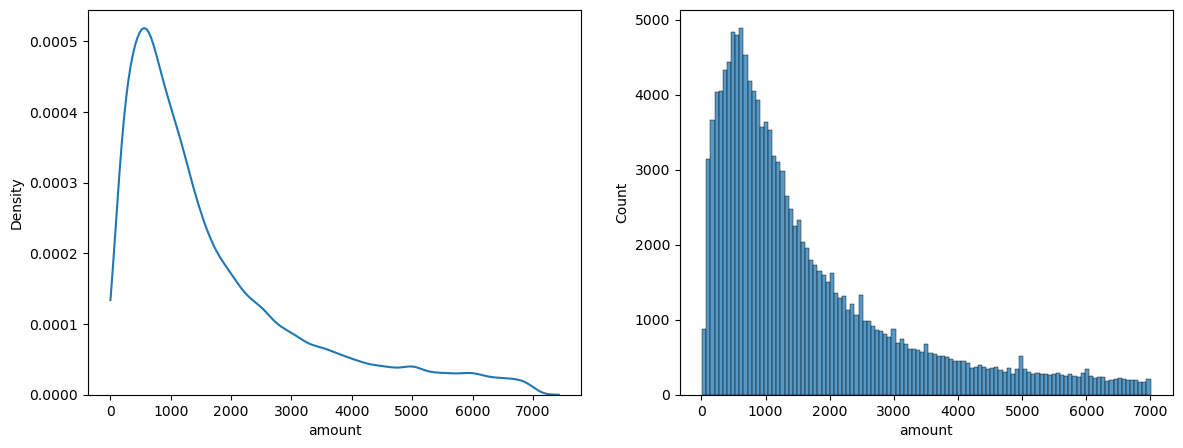

In [25]:
fig, axes = plt.subplots(1,2, figsize = (14, 5))
sns.kdeplot(public_M['amount'], clip = (0, None), ax = axes[0])
sns.histplot(public_M['amount'], ax = axes[1])

In [26]:
public_M['paid_binary'] = public_M['paid_date'].notna()
def onezero(condition):
    if condition:
        return 1
    else:
        return 0
public_M['paid_binary'] = public_M['paid_binary'].map(onezero)

monetary (valid) VS non-monetary cases

In [27]:
public_M.isna().sum()

analytics_matchkey                       0
industry_code_kind_of_business           0
reporting_subscriber_code                0
public_record_type_code                  0
effective_date_date_verified             0
filed_date                               0
paid_date                            73695
amount                                   0
public_record_source_type_code           0
equal_credit_opportunity_act_code        0
legislative_prohibited_code              0
paid_binary                              0
dtype: int64

count unique values
whether paid depends on case type!!
count categorical values for paid/unpaid

do any of public records variables (esp. categorical) influence presence of a particular analytics_matchkey from public records in the merged dataset? what are the biggest proportions of analytics_matchkey in merged to matchkey in public?

# Two databases together